## Etapa de preprocesamiento de los datos - Model LSTM_1

### Montaje del la unidad Drive institucional.

In [ ]:
# Neccesary
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Librerías

In [ ]:
# Neccesary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
from time import process_time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import plot_confusion_matrix

### Preparación de los datos - REDD para la LSTM


In [ ]:
# Primero definimos la función read_label(), esta nos permite leer cada etiqueta presente en el archivo .dat de cada casa. 
def read_label():
    label = {}
    for i in range(1, 7):
        hi = '/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')
print(labels)

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

{1: {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'wash

In [ ]:
# Con la función read_merge_data se une los valores de potencia con sus respectivas marcas temporales, creando un pandas dataframe. 
def read_merge_data(house):
    path = '/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'}) 
        df = pd.merge(df, data, how = 'inner', on = 'unix_time') 
    df['timestamp'] = df['unix_time'].astype("datetime64[s]") 
    df = df.set_index(df['timestamp'].values) 
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [ ]:
# Creamos un sub data frame (dates) para almacenar la información temporal de cada casa (Fecha de inicio\fin)
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



Se escoge un split aproximadamente de 70 % training - 30 % test. Esto se hace ya que no se cuenta con tanta información.

In [ ]:
# Se separa la información de la casa 1 en entrenamiento/validación/prueba
# Revisar, el split utilizado es otro este es un 70/30 - pero en realidad se usó un 75/25. 
df1_train = df[1].loc[:dates[1][13]]
df1_test = df[1].loc[dates[1][14]:]
print(df[1].shape) # Confirmación que se esten tomando todas las muestras.
print('df_train.shape: ', df1_train.shape)
print('df_test.shape: ', df1_test.shape)
df1_top = df1_train.head
print(df1_top)

(406748, 20)
df_train.shape:  (278782, 20)
df_test.shape:  (127966, 20)
<bound method NDFrame.head of                      mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   
...                      ...      ...     ...     ...             ...   
2011-05-02 23:59:43    53.74    38.41     0.0     0.0             6.0   
2011-05-02 23:59:46    56.36    38.31     0.0     0.0             7.0   
2011-05-02 23:59:50    53.98    38.24     0.0     0.0             6.0   
2011-05-02 23:59:54    56.87    38.40     0.0     0.0             6.0   
2011-05-02 23:59:58    56.99    38.57     0.0     0.0             6.0   

                     

La siguiente función es necesario ejecutarla solo 1 vez. Luego se guardan los resultados en un binario. Si se cambian los párametros de los datos de la LSTM o se altera la relación entrenamiento/test es necesario volver a correr la función.

Salvamos estos arreglos de numpy para no tener que estar usando la función process_data, cuyo tiempo de ejecución supera los 15 minutos. Guardando los binarios el proceso demora menos de 10 segundos!

### Funciones auxiliares

In [ ]:
# La siguiente función permite graficar los resultados predecidos con respecto a los reales.
def plot_each_app(df, dates, predict, y_test, title, time_steps = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[time_steps:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)

In [ ]:
# Esta función se implementa para convertir los datos de potencia de un electrodoméstico 
# a información de activación y apagado/sueño. Para ello pongo un treshold de 10 W. 
# Una tarea pendiente es evaluar una forma de identificar automaticamente el 
# Threshold sin necesidad de analizar cada electrodoméstico por separado. 
def labeling_elec(y_train):
    y_train_labeled = np.array([])
    num_y_train = len(y_train)
    for power_reading in range(num_y_train):
        if y_train[power_reading] < 50:
            y_train_labeled = np.append(y_train_labeled,[0])
        else:
            y_train_labeled = np.append(y_train_labeled,[1])
    return y_train_labeled

In [ ]:
# Esta función permite calcular la potencia promedio consumida por 1 electrodoméstico en un periodo
# de tiempo previamente determinado.
def power_reading(pred_data, power_consumption):
    sump = 0
    for power in pred_data:
        if power == 1:
            sump += power_consumption
    avep = round(sump/len(pred_data))
    return avep

In [ ]:
# Average power reading for a window of measures in the regression problem.
def power_reading_regression(pred_data):
    sump = 0
    for i in range(len(pred_data)):
        sump += pred_data[i]
    avep = round(sump/len(pred_data))
    return avep

## Carga de datos LSTM

### T_step = 10

Cargamos los arreglos numpy previamente creados:

In [ ]:
X_train = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/X_train.npy')
y_train = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/y_train.npy')
X_test = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/X_test.npy')
y_test = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/y_test.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(305048, 10, 2) (305048, 18) (101470, 10, 2) (101470, 18)


En el siguiente bloque de código se visualiza la información con la que contamos.

In [ ]:
print(y_train[1:10]) # Aqui podemos observar que tenemos las 18 lecturas de energía.
print(X_train[1:4]) # Aqui tenemos un arreglo con un step time de 10, el cual movemos a través de las lecturas agregadas,
                    # Nuestro algoritmo tendrá de entrada la señal agregada de consumo y tratará de predecir la presencia/ausencia
                    # de cada uno de los electrodomésticos.

[[ 0.  0.  6.  1. 39. 21. 82.  0.  5.  1.  0.  0.  1.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 34. 22. 81.  0.  5.  1.  0.  0.  2.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 38. 21. 81.  0.  5.  1.  0.  0.  1.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 39. 21. 82.  0.  5.  1.  0.  0.  1.  0. 66. 46.  0.  0.]
 [ 0.  0.  6.  1. 37. 22. 81.  0.  5.  1.  0.  0.  2.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 34. 21. 81.  0.  5.  1.  0.  0.  1.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  1. 36. 22. 81.  0.  5.  1.  0.  0.  1.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 38. 21. 81.  0.  5.  1.  0.  0.  1.  0. 65. 46.  0.  0.]
 [ 0.  0.  6.  0. 35. 22. 81.  0.  5.  1.  0.  0.  2.  0. 65. 46.  0.  0.]]
[[[223.17 119.19]
  [223.6  118.92]
  [222.91 119.16]
  [222.94 118.83]
  [222.9  118.76]
  [222.96 118.88]
  [222.54 118.36]
  [226.03 119.17]
  [222.96 119.03]
  [223.52 118.82]]

 [[223.6  118.92]
  [222.91 119.16]
  [222.94 118.83]
  [222.9  118.76]
  [222.96 118.88]
  [222.54 118.36]
  [226.03 119.17]
  [222.96 119.03

Opción 2: TimeStep = 100

In [ ]:
X_data_House1_stp3 = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/X_data_House1_stp3.npy')
y_data_House1_stp3 = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/y_data_House1_stp3.npy')

### T_step = 3

Cargamos los arreglos numpy previamente creados:

In [ ]:
X_train = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/X_train_D3.npy')
y_train = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/y_train_D3.npy')
X_test = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/X_test_D3.npy')
y_test = np.load(r'/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/y_test_D3.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(305160, 3, 2) (305160, 18) (101519, 3, 2) (101519, 18)


# Model LSTM_1

Características del modelo LSTM_1:


*   TimeStep: 10.
*   1ra Capa: 256 neuronas.
*   2da Capa: 64 neuronas.
*   Dropout: 0.2 en ambas capas.
*   Función de activación: ReLU
*   Adam lr: 0.0005.
*   Batch_size: (N=800, L=1000, M=100).
*   Epochs: 100.
*   Validation split: 80-10-10.
*   Loss: 'mean_squared_error'.
*   Monitor metric: "val_loss".

## Nevera

In [ ]:
nevera_LSMT_1 = Sequential()
nevera_LSMT_1.add(LSTM(256, input_shape=(None, 2), activation='relu', return_sequences=True))
nevera_LSMT_1.add(Dropout(0.2))
nevera_LSMT_1.add(LSTM(64, activation='relu'))
nevera_LSMT_1.add(Dropout(0.2))
nevera_LSMT_1.add(Dense(1))
nevera_LSMT_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         265216    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 347,457
Trainable params: 347,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
adam = Adam(learning_rate=0.0005)
nevera_LSMT_1.compile(loss='mean_squared_error', optimizer=adam)
# Con el checkpointer guardamos los hiperparametros que consiguen los mejores resultados en el set de validación.

checkpointer = ModelCheckpoint(filepath="/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSMT_1.hdf5", monitor="val_loss", verbose=0, save_best_only=True)
hist_nevera_LSMT_1 = nevera_LSMT_1.fit(
            X_train,
            y_train[:,2],
            batch_size=800,
            verbose=1,
            epochs=20,
            validation_split=0.1,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/20
344/344 [==============================] - 46s 113ms/step - loss: 9703.7002 - val_loss: 6294.5879
Epoch 2/20
344/344 [==============================] - 35s 103ms/step - loss: 7406.1509 - val_loss: 6446.6729
Epoch 3/20
344/344 [==============================] - 35s 102ms/step - loss: 7243.5264 - val_loss: 7530.8027
Epoch 4/20
344/344 [==============================] - 36s 105ms/step - loss: 6880.6987 - val_loss: 7111.5762
Epoch 5/20
344/344 [==============================] - 35s 102ms/step - loss: 5860.2651 - val_loss: 3424.8525
Epoch 6/20
344/344 [==============================] - 36s 104ms/step - loss: 4334.6904 - val_loss: 1996.9714
Epoch 7/20
344/344 [==============================] - 36s 104ms/step - loss: 3929.8269 - val_loss: 1558.8813
Epoch 8/20
344/344 [==============================] - 35s 103ms/step - loss: 3297.9453 - val_loss: 1588.9891
Epoch 9/20
344/344 [==============================] - 36s 104ms/step - loss: 3173.8894 - val_loss: 1516.6683
Epoch 10/20
344/344

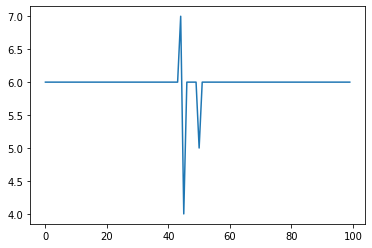

In [ ]:
plt.plot(y_train[0:100,2])

### Validation with all the data.

In [ ]:
load_nevera_LSMT_1 = load_model('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSMT_1.hdf5')
t1_start = process_time() 
pred_nevera_LSMT_1 = load_nevera_LSMT_1.predict(X_test[:]).reshape(-1)
t1_stop = process_time()
print(pred_nevera_LSMT_1.shape)
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

(101470,)
Elapsed time during the whole program in seconds: 28.05013372099984


In [ ]:
power_reading_regression(pred_nevera_LSMT_1)

53

In [ ]:
def rmse_loss(y_predict, y):
    return np.sqrt(np.mean(np.square(y_predict - y)))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [ ]:
rmse_loss_nevera_LSMT_1 = rmse_loss(pred_nevera_LSMT_1, y_test[:,2])
mae_loss_nevera_LSMT_1 = mae_loss(pred_nevera_LSMT_1, y_test[:,2])
print('Root mean square error on test set: ', rmse_loss_nevera_LSMT_1)
print('Mean absolute error on the test set: ', mae_loss_nevera_LSMT_1)

Root mean square error on test set:  43.87636116490037
Mean absolute error on the test set:  13.998295281137095


In [ ]:
def labeling_elec(y_train, tresh):
    y_train_labeled = np.array([])
    num_y_train = len(y_train)
    for power_reading in range(num_y_train):
        if y_train[power_reading] < tresh:
            y_train_labeled = np.append(y_train_labeled,[0])
        else:
            y_train_labeled = np.append(y_train_labeled,[1])
    return y_train_labeled

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Finding best tresh:
def best_tresh(init, y_train, top_tresh):
    test_tresh = init
    best_f1_score = 0
    f1_scores = []
    test_treshs = []
    while test_tresh < top_tresh:
        y_pred_labeled = labeling_elec(y_train, test_tresh)
        y_test_labeled = labeling_elec(y_test[:,2], test_tresh)
        cm = confusion_matrix(y_test_labeled, y_pred_labeled)
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        C_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specifity = TN / (TN + FP)
        fp_rate = FP / float(TN + FP)
        precision = TP / float(TP + FP)
        f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
        f1_scores.append(f1_score)
        test_treshs.append(test_tresh)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_tresh = test_tresh
        test_tresh += 5
    return best_f1_score, best_tresh, f1_scores, test_treshs

In [ ]:
best_f1_score, best_tresh, f1_scores, test_treshs = best_tresh(20, pred_nevera_LSMT_1, 100)

In [ ]:
print(best_f1_score)
print(best_tresh)
print(f1_scores)
print(test_treshs)

0.9402001464486209
75
[0.9051520241319028, 0.905715614183127, 0.9129761428297979, 0.9169613162961667, 0.9199922612870886, 0.9197121490052208, 0.9254208663468622, 0.9250343878954609, 0.9269320928204103, 0.9317431936738494, 0.9348181750576338, 0.9402001464486209, 0.935911518503087, 0.9351271234750884, 0.9330432127042296, 0.9275941583397387]
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


In [ ]:
y_pred_labeled = labeling_elec(pred_nevera_LSMT_1, 75)

In [ ]:
y_test_labeled = labeling_elec(y_test[:,2], 75)

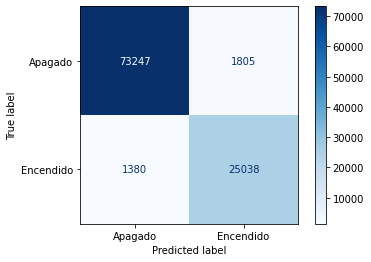

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Apagado", "Encendido"]

cm = confusion_matrix(y_test_labeled, y_pred_labeled)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
C_error = (FP + FN) / float(TP + TN + FP + FN)
sensitivity = TP / float(FN + TP)
specifity = TN / (TN + FP)
fp_rate = FP / float(TN + FP)
precision = TP / float(TP + FP)
f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
print("Classification Accuracy:", C_accuracy)
print("Classification Error:", C_error)
print("Sensitivity:", sensitivity)
print("Specifity:", specifity)
print("False Positive Rate:", fp_rate)
print("Precision:", precision)
print("F1 Score:", f1_score)

Classification Accuracy: 0.968611412240071
Classification Error: 0.031388587759929046
Sensitivity: 0.9477628889393596
Specifity: 0.9759500079944572
False Positive Rate: 0.024049992005542822
Precision: 0.932757143389338
F1 Score: 0.9402001464486209


### Validation with 40 examples.

In [ ]:
load_nevera_LSMT_1 = load_model('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSMT_1.hdf5')
t1_start = process_time() 
pred_nevera_LSMT_1 = load_nevera_LSMT_1.predict(X_test[:32000], batch_size=800).reshape(-1)
t1_stop = process_time()
print(pred_nevera_LSMT_1.shape)
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

(32000,)
Elapsed time during the whole program in seconds: 0.9379517830000168


In [ ]:
power_reading_regression(pred_nevera_LSMT_1)

49

In [ ]:
def rmse_loss(y_predict, y):
    return np.sqrt(np.mean(np.square(y_predict - y)))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [ ]:
def NoZeros_Fn(True_Values, predicted_Values):
    True_Values_NoZeros = []
    predicted_Values_NoZeros = []
    for i in range(len(True_Values)):
        if True_Values[i] > 10:
            True_Values_NoZeros.append(True_Values[i])
            predicted_Values_NoZeros.append(predicted_Values[i])
    return True_Values_NoZeros, predicted_Values_NoZeros

In [ ]:
True_Values_NoZeros, predicted_Values_NoZeros = NoZeros_Fn(y_test[:32000,2], pred_nevera_LSMT_1)

In [ ]:
rmse_loss_nevera_LSMT_1 = rmse_loss(pred_nevera_LSMT_1, y_test[:32000,2])
mae_loss_nevera_LSMT_1 = mae_loss(pred_nevera_LSMT_1, y_test[:32000,2])
mape_loss_nevera_LSMT_1 = mean_absolute_percentage_error(True_Values_NoZeros, predicted_Values_NoZeros)
print('Root mean square error on test set: ', rmse_loss_nevera_LSMT_1)
print('Mean absolute error on the test set: ', mae_loss_nevera_LSMT_1)
print('Mean absolute percentage error on the test set: ', mape_loss_nevera_LSMT_1)

Root mean square error on test set:  35.63782546592558
Mean absolute error on the test set:  9.266368863295764
Mean absolute percentage error on the test set:  0.11769583413647913


In [ ]:
def labeling_elec(y_train, tresh):
    y_train_labeled = np.array([])
    num_y_train = len(y_train)
    for power_reading in range(num_y_train):
        if y_train[power_reading] < tresh:
            y_train_labeled = np.append(y_train_labeled,[0])
        else:
            y_train_labeled = np.append(y_train_labeled,[1])
    return y_train_labeled

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Finding best tresh:
def best_tresh(init, y_train, y_test, top_tresh):
    test_tresh = init
    best_f1_score = 0
    f1_scores = []
    test_treshs = []
    while test_tresh < top_tresh:
        y_pred_labeled = labeling_elec(y_train, test_tresh)
        y_test_labeled = labeling_elec(y_test, test_tresh)
        cm = confusion_matrix(y_test_labeled, y_pred_labeled)
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        C_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specifity = TN / (TN + FP)
        fp_rate = FP / float(TN + FP)
        precision = TP / float(TP + FP)
        f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
        f1_scores.append(f1_score)
        test_treshs.append(test_tresh)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_tresh = test_tresh
        test_tresh += 5
    return best_f1_score, best_tresh, f1_scores, test_treshs

In [ ]:
best_f1_score, best_tresh, f1_scores, test_treshs = best_tresh(20, pred_nevera_LSMT_1, y_test[:32000,2], 100)

In [ ]:
print(best_f1_score)
print(best_tresh)
print(f1_scores)
print(test_treshs)

0.9665601981617885
75
[0.9336734693877552, 0.9364623642491574, 0.9383055937930171, 0.9389494797542937, 0.9397439116244037, 0.9408362150267212, 0.9448520111307868, 0.9445185891325071, 0.9458065337833536, 0.9588634162092348, 0.9647548445831707, 0.9665601981617885, 0.9600052624654651, 0.9605904837221563, 0.9619701571371979, 0.9612023305084746]
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


In [ ]:
y_pred_labeled = labeling_elec(pred_nevera_LSMT_1, 75)

In [ ]:
y_test_labeled = labeling_elec(y_test[:32000,2], 75)

In [ ]:
%config InlineBackend.figure_format ='retina'

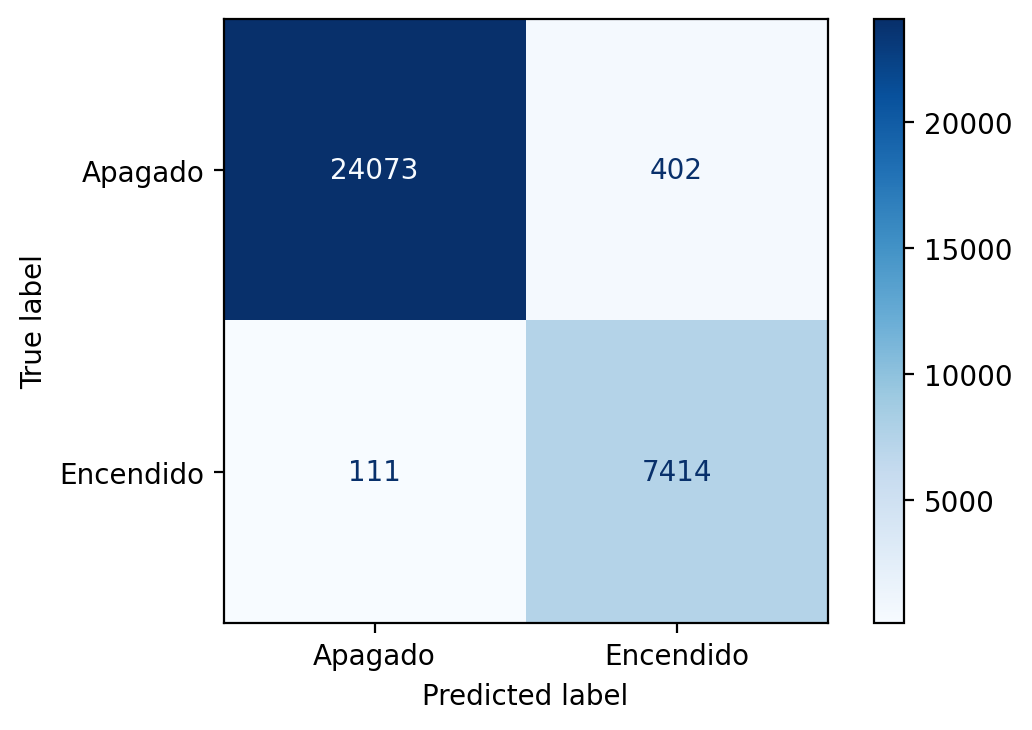

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Apagado", "Encendido"]

cm = confusion_matrix(y_test_labeled, y_pred_labeled)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.rcParams['figure.dpi'] = 50
plt.show()

Text(0.5, 0, 'Predicated Label')

<Figure size 432x288 with 0 Axes>

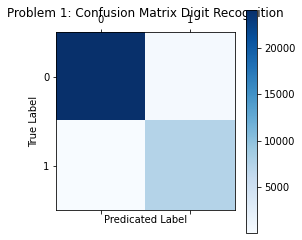

In [ ]:
    fig = plt.figure()
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Problem 1: Confusion Matrix Digit Recognition')
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')

<Figure size 432x288 with 0 Axes>

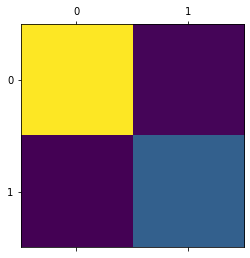

In [ ]:
fig = plt.figure()
plt.matshow(cm)
fig.savefig('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Plots_Collab/disp.png', dpi=400)

In [ ]:
disp.savefig('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Plots_Collab/disp.png', dpi=400)

AttributeError: ignored

In [ ]:
C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
C_error = (FP + FN) / float(TP + TN + FP + FN)
sensitivity = TP / float(FN + TP)
specifity = TN / (TN + FP)
fp_rate = FP / float(TN + FP)
precision = TP / float(TP + FP)
f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
print("Classification Accuracy:", C_accuracy)
print("Classification Error:", C_error)
print("Sensitivity:", sensitivity)
print("Specifity:", specifity)
print("False Positive Rate:", fp_rate)
print("Precision:", precision)
print("F1 Score:", f1_score)

Classification Accuracy: 0.98396875
Classification Error: 0.01603125
Sensitivity: 0.9852491694352159
Specifity: 0.9835750766087845
False Positive Rate: 0.016424923391215526
Precision: 0.9485670419651996
F1 Score: 0.9665601981617885


# Model LSTM_2

Características del modelo LSTM_1:


*   TimeStep: 10.
*   1ra Capa: 256 neuronas.
*   2da Capa: 64 neuronas.
*   Dropout: 0.2 en ambas capas.
*   Función de activación: ReLU
*   Adam lr: 0.0005.
*   Batch_size: (N=800, L=1000, M=100).
*   Epochs: 100.
*   Validation split: 80-10-10.
*   Loss: 'mean_squared_error'.
*   Monitor metric: "val_loss".

## Nevera

In [ ]:
nevera_LSTM_2 = Sequential()
nevera_LSTM_2.add(LSTM(256, input_shape=(None, 2), activation='relu', return_sequences=True))
nevera_LSTM_2.add(Dropout(0.225))
nevera_LSTM_2.add(LSTM(64, activation='relu'))
nevera_LSTM_2.add(Dropout(0.225))
nevera_LSTM_2.add(Dense(1))
nevera_LSTM_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 256)         265216    
                                                                 
 dropout_8 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 347,457
Trainable params: 347,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
adam = Adam(learning_rate=0.001)
nevera_LSTM_2.compile(loss='mean_squared_error', optimizer=adam)
# Con el checkpointer guardamos los hiperparametros que consiguen los mejores resultados en el set de validación.

checkpointer = ModelCheckpoint(filepath="/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSTM_2.hdf5", monitor="val_loss", verbose=0, save_best_only=True)
hist_nevera_LSTM_2 = nevera_LSTM_2.fit(
            X_train,
            y_train[:,2],
            batch_size=800,
            verbose=1,
            epochs=25,
            validation_split=0.1,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/25
344/344 [==============================] - 19s 41ms/step - loss: 3412.6714 - val_loss: 925.1632
Epoch 2/25
344/344 [==============================] - 15s 43ms/step - loss: 2235.4937 - val_loss: 824.2677
Epoch 3/25
344/344 [==============================] - 14s 40ms/step - loss: 1720.2030 - val_loss: 659.1941
Epoch 4/25
344/344 [==============================] - 13s 38ms/step - loss: 1625.6504 - val_loss: 749.5850
Epoch 5/25
344/344 [==============================] - 15s 42ms/step - loss: 1612.5781 - val_loss: 633.2925
Epoch 6/25
344/344 [==============================] - 13s 39ms/step - loss: 1677.6844 - val_loss: 694.2531
Epoch 7/25
344/344 [==============================] - 14s 41ms/step - loss: 1639.7754 - val_loss: 558.2487
Epoch 8/25
344/344 [==============================] - 13s 39ms/step - loss: 1756.3660 - val_loss: 691.2264
Epoch 9/25
344/344 [==============================] - 13s 39ms/step - loss: 1692.6580 - val_loss: 1308.6932
Epoch 10/25
344/344 [===============

### Validation with all the data.

In [ ]:
load_nevera_LSTM_2 = load_model('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSTM_2.hdf5')
t1_start = process_time() 
pred_nevera_LSTM_2 = load_nevera_LSTM_2.predict(X_test[:]).reshape(-1)
t1_stop = process_time()
print(pred_nevera_LSTM_2.shape)
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

(101470,)
Elapsed time during the whole program in seconds: 30.522713022


In [ ]:
power_reading_regression(pred_nevera_LSTM_2)

1449

In [ ]:
def rmse_loss(y_predict, y):
    return np.sqrt(np.mean(np.square(y_predict - y)))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [ ]:
rmse_loss_nevera_LSTM_2 = rmse_loss(pred_nevera_LSTM_2, y_test[:,2])
mae_loss_nevera_LSTM_2 = mae_loss(pred_nevera_LSTM_2, y_test[:,2])
print('Root mean square error on test set: ', rmse_loss_nevera_LSTM_2)
print('Mean absolute error on the test set: ', mae_loss_nevera_LSTM_2)

Root mean square error on test set:  1508.5135434110462
Mean absolute error on the test set:  1391.5519343590588


In [ ]:
def labeling_elec(y_train, tresh):
    y_train_labeled = np.array([])
    num_y_train = len(y_train)
    for power_reading in range(num_y_train):
        if y_train[power_reading] < tresh:
            y_train_labeled = np.append(y_train_labeled,[0])
        else:
            y_train_labeled = np.append(y_train_labeled,[1])
    return y_train_labeled

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Finding best tresh:
def best_tresh(init, y_train, top_tresh):
    test_tresh = init
    best_f1_score = 0
    f1_scores = []
    test_treshs = []
    while test_tresh < top_tresh:
        y_pred_labeled = labeling_elec(y_train, test_tresh)
        y_test_labeled = labeling_elec(y_test[:,2], test_tresh)
        cm = confusion_matrix(y_test_labeled, y_pred_labeled)
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        C_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specifity = TN / (TN + FP)
        fp_rate = FP / float(TN + FP)
        precision = TP / float(TP + FP)
        f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
        f1_scores.append(f1_score)
        test_treshs.append(test_tresh)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_tresh = test_tresh
        test_tresh += 5
    return best_f1_score, best_tresh, f1_scores, test_treshs

In [ ]:
best_f1_score, best_tresh, f1_scores, test_treshs = best_tresh(20, pred_nevera_LSTM_2, 100)

In [ ]:
print(best_f1_score)
print(best_tresh)
print(f1_scores)
print(test_treshs)

0.42238584324000716
30
[0.42236855403608886, 0.4223727074116979, 0.42238584324000716, 0.4223613108890876, 0.42233677777518597, 0.42180913121256897, 0.4131733717074392, 0.413177118365687, 0.4131803499221788, 0.4131808653755905, 0.4131786644556213, 0.41320827042376923, 0.41322171804099517, 0.41321305344526765, 0.4132324520566166, 0.4132237871674492]
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


Nota: Se escogió 20 como umbral.

In [ ]:
y_pred_labeled = labeling_elec(pred_nevera_LSTM_2, 95)

In [ ]:
y_test_labeled = labeling_elec(y_test[:,2], 95)

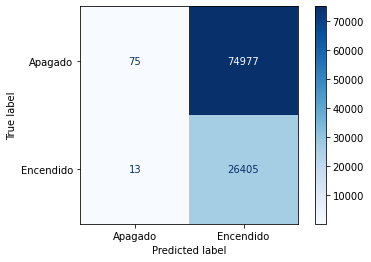

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Apagado", "Encendido"]

cm = confusion_matrix(y_test_labeled, y_pred_labeled)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
C_error = (FP + FN) / float(TP + TN + FP + FN)
sensitivity = TP / float(FN + TP)
specifity = TN / (TN + FP)
fp_rate = FP / float(TN + FP)
precision = TP / float(TP + FP)
f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
print("Classification Accuracy:", C_accuracy)
print("Classification Error:", C_error)
print("Sensitivity:", sensitivity)
print("Specifity:", specifity)
print("False Positive Rate:", fp_rate)
print("Precision:", precision)
print("F1 Score:", f1_score)

Classification Accuracy: 0.9636718249785754
Classification Error: 0.03632817502142456
Sensitivity: 0.9780817887614004
Specifity: 0.9584000430529955
False Positive Rate: 0.041599956947004454
Precision: 0.8958501751549448
F1 Score: 0.9351617440225035


### Validation with 40 examples.

In [ ]:
load_nevera_LSTM_2 = load_model('/content/drive/Shareddrives/TG_NILM/00_Backend/Code_Backend/Models/nevera_LSTM_2.hdf5')
t1_start = process_time() 
pred_nevera_LSTM_2 = load_nevera_LSTM_2.predict(X_test[:32000], batch_size = 800).reshape(-1)
t1_stop = process_time()
print(pred_nevera_LSTM_2.shape)
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

(32000,)
Elapsed time during the whole program in seconds: 0.7160929879996729


In [ ]:
power_reading_regression(pred_nevera_LSTM_2)

51

In [ ]:
def rmse_loss(y_predict, y):
    return np.sqrt(np.mean(np.square(y_predict - y)))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [ ]:
def NoZeros_Fn(True_Values, predicted_Values):
    True_Values_NoZeros = []
    predicted_Values_NoZeros = []
    for i in range(len(True_Values)):
        if True_Values[i] > 10:
            True_Values_NoZeros.append(True_Values[i])
            predicted_Values_NoZeros.append(predicted_Values[i])
    return True_Values_NoZeros, predicted_Values_NoZeros

In [ ]:
True_Values_NoZeros, predicted_Values_NoZeros = NoZeros_Fn(y_test[:32000,2], pred_nevera_LSTM_2)

In [ ]:
rmse_loss_nevera_LSTM_2 = rmse_loss(pred_nevera_LSTM_2, y_test[:32000,2])
mae_loss_nevera_LSTM_2 = mae_loss(pred_nevera_LSTM_2, y_test[:32000,2])
mape_loss_nevera_LSTM_2 = mean_absolute_percentage_error(True_Values_NoZeros, predicted_Values_NoZeros)
print('Root mean square error on test set: ', rmse_loss_nevera_LSTM_2)
print('Mean absolute error on the test set: ', mae_loss_nevera_LSTM_2)
print('Mean absolute percentage error on the test set: ', mape_loss_nevera_LSTM_2)

Root mean square error on test set:  32.29077898036751
Mean absolute error on the test set:  6.827448520995676
Mean absolute percentage error on the test set:  0.0855790597186892


In [ ]:
def labeling_elec(y_train, tresh):
    y_train_labeled = np.array([])
    num_y_train = len(y_train)
    for power_reading in range(num_y_train):
        if y_train[power_reading] < tresh:
            y_train_labeled = np.append(y_train_labeled,[0])
        else:
            y_train_labeled = np.append(y_train_labeled,[1])
    return y_train_labeled

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Finding best tresh:
def best_tresh(init, y_train, y_test, top_tresh):
    test_tresh = init
    best_f1_score = 0
    f1_scores = []
    test_treshs = []
    while test_tresh < top_tresh:
        y_pred_labeled = labeling_elec(y_train, test_tresh)
        y_test_labeled = labeling_elec(y_test, test_tresh)
        cm = confusion_matrix(y_test_labeled, y_pred_labeled)
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        C_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        C_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specifity = TN / (TN + FP)
        fp_rate = FP / float(TN + FP)
        precision = TP / float(TP + FP)
        f1_score = 2*((sensitivity*precision)/(sensitivity+precision))
        f1_scores.append(f1_score)
        test_treshs.append(test_tresh)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_tresh = test_tresh
        test_tresh += 5
    return best_f1_score, best_tresh, f1_scores, test_treshs

In [ ]:
best_f1_score, best_tresh, f1_scores, test_treshs = best_tresh(20, pred_nevera_LSTM_2, y_test[:32000,2], 100)

In [ ]:
print(best_f1_score)
print(best_tresh)
print(f1_scores)
print(test_treshs)

0.978232362968791
80
[0.9480781348456206, 0.9489686494669779, 0.9495077000757383, 0.9510082811808585, 0.9514771936483837, 0.9536491027835902, 0.9557070932381619, 0.9542140938738969, 0.955436035343834, 0.9737030995106036, 0.9755491631799162, 0.9775943396226415, 0.978232362968791, 0.969893469198703, 0.9699576495500265, 0.9703389830508475]
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


In [ ]:
y_pred_labeled = labeling_elec(pred_nevera_LSTM_2, 80)

In [ ]:
y_test_labeled = labeling_elec(y_test[:32000,2], 80)

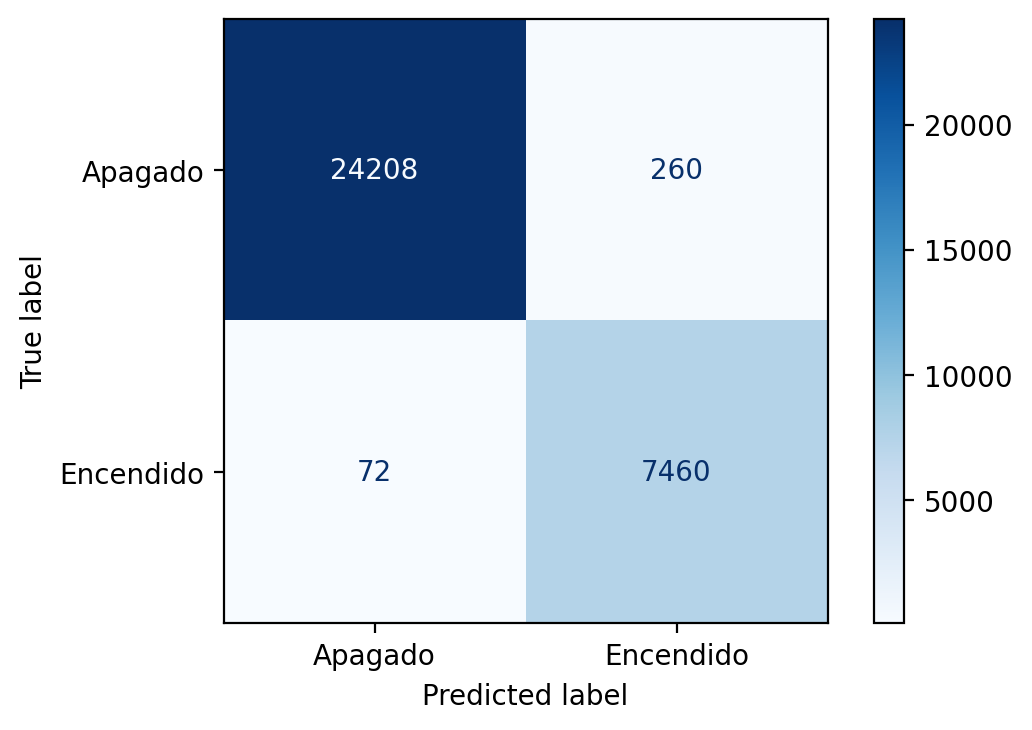

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Apagado", "Encendido"]

cm = confusion_matrix(y_test_labeled, y_pred_labeled)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()